In [1]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
import seaborn as sns

# plt.style.use(['science','ieee'])
pd.options.mode.chained_assignment = None  # default='warn'

In [87]:
configs = ['6P', '4P-2E', '3P-3E', '2P-4E'][::-1]
games = ['xonotic', 'supertux']
scheds = ['cfs-eas', 'cfs-no-eas']

In [3]:
def to_sched_config(df):
    df_sched_config = {}

    for sched in scheds:
        df_sched = df[df.scheduler == sched]
        df_config = {}
        for config in configs:
            df_config[config] = df_sched[df_sched.cpu_config == config]
        df_sched_config[sched] = df_config
    return df_sched_config

In [4]:
def to_game(df):
    df_game = {}

    for game in games:
        df_game[game] = df[df.game == game]
    return df_game

In [5]:
def import_data_(config, game, sched):
    path_prefix = f"../results/results-{sched}/{game}/{config}"
    outputs = os.listdir(path_prefix)


    scaphandres = list(filter(lambda file: file.startswith('scaph'), outputs))
    scaphandres = list(filter(lambda file: file.endswith('parsed'), scaphandres))
    mangologs = list(filter(lambda file: file.startswith(game), outputs))
    pcms = list(filter(lambda file: file.startswith('pcm'), outputs))

    def suffix(x):
        return x.split('/')[-1]


    host = []
    socket = []
    processes = []

    idx = 0

    scaph_2 = f"{path_prefix}/{scaphandres[idx]}"
    mango_2 = f"{path_prefix}/{mangologs[idx]}"
    pcm = f"{path_prefix}/{pcms[idx]}"

    with open(scaph_2) as file:
        content = file.readlines()
        for index, line in enumerate(content[:-1]):
            if line.strip() != '':
                line_ = json.loads(line)
                host.append([line_['host']['timestamp'],line_['host']['consumption']])
                socket.append([line_['sockets'][0]['domains'][0]['timestamp'],
                 line_['sockets'][0]['consumption'], 
                 line_['sockets'][0]['domains'][1]['consumption'], 
                 line_['sockets'][0]['domains'][0]['consumption']])

                processes += list(map(
                    lambda x: [x['timestamp'],suffix(x['exe']),x['pid'],x['consumption']], 
                    line_['consumers']))

    host = pd.DataFrame(host, columns=['timestamp', 'energy'])
    socket = pd.DataFrame(socket, columns=['timestamp', 'socket', 'core', 'uncore'])
    processes = pd.DataFrame(processes, columns=['timestamp', 'process', 'pid', 'energy'])

    host['timestamp'] -= host.iloc[0].timestamp
    socket['timestamp'] -= socket.iloc[0].timestamp
    processes['timestamp'] -= processes.iloc[0].timestamp

    host['energy'] *= 1e-6
    socket['core'] *= 1e-6
    socket['uncore'] *= 1e-6
    socket['socket'] *= 1e-6
    processes['energy'] *= 1e-6

    duration = host.timestamp.iloc[-1] - host.timestamp.iloc[0]

    host['time_delta'] = host.timestamp.diff()
    host['edp'] = host.time_delta * host.energy

    processes['time_delta'] = processes.timestamp.diff()
    processes['edp'] = processes.time_delta * processes.energy

    mango_df = pd.read_csv(mango_2, skiprows=2)
    game_power_df = processes[processes.process.str.startswith(game)]
    game_perf_df = mango_df
    pcm_df = pd.read_csv(pcm, skiprows=1)
    
    game_power_df['cpu_config'] = config
    game_power_df['scheduler'] = sched
    game_power_df['game'] = game
    game_perf_df['cpu_config'] = config
    game_perf_df['scheduler'] = sched
    game_perf_df['game'] = game
    pcm_df['cpu_config'] = config
    pcm_df['scheduler'] = sched
    pcm_df['game'] = game
    host['cpu_config'] = config
    host['scheduler'] = sched
    host['game'] = game
    socket['cpu_config'] = config
    socket['scheduler'] = sched
    socket['game'] = game

    
    return game_power_df, game_perf_df, pcm_df, host, socket

In [6]:
def import_data(configs, games, scheds):
    game_power_df = []
    game_perf_df = []
    pcm_df = [] 
    host = []
    socket = []
    
    for config in configs:
        for game in games:
            for sched in scheds:
                game_power_df_, game_perf_df_, pcm_df_, host_, socket_ = import_data_(config=config, game=game, sched=sched)
                game_power_df.append(game_power_df_)
                game_perf_df.append(game_perf_df_)
                pcm_df.append(pcm_df_)
                host.append(host_)
                socket.append(socket_)
    
    game_power_df = pd.concat(game_power_df, axis=0)
    game_perf_df = pd.concat(game_perf_df, axis=0)
    pcm_df = pd.concat(pcm_df, axis=0)
    host = pd.concat(host, axis=0)
    socket = pd.concat(socket, axis=0)
    
    pcm_df['datetime'] = pd.to_datetime(pcm_df.Date + ' ' + pcm_df.Time)
    game_power_df['timedelta'] = pd.to_timedelta(game_power_df.timestamp, unit='s')
    game_perf_df['timedelta'] = pd.to_timedelta(game_perf_df.elapsed, unit='ns')
    
    return game_power_df, game_perf_df, pcm_df, host, socket

In [7]:
game_power_df, game_perf_df, pcm_df, host, socket = import_data(configs, games, scheds)

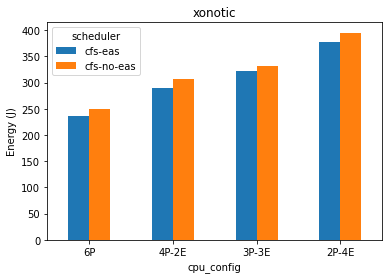

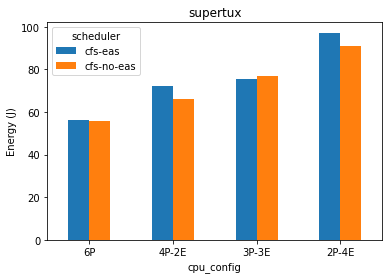

In [8]:
game_power_game = to_game(game_power_df)

for game in games:
    df = game_power_game[game].groupby(['cpu_config', 'scheduler', 'game']).sum(numeric_only=True).reset_index()
    t = pd.pivot_table(df, index=['cpu_config'], columns=['scheduler'], values=['energy', 'edp'])
    t.iloc[::-1].plot.bar(y='energy', ylabel='Energy (J)', title=game)
    plt.xticks(rotation=0)
    plt.show()

In [9]:
cols_idx = ['cpu_config', 'scheduler', 'game']
df = socket.groupby(cols_idx).sum().reset_index()

In [10]:
df_config = {}
for config in configs:
    df_config[config] = df[df.cpu_config == config]

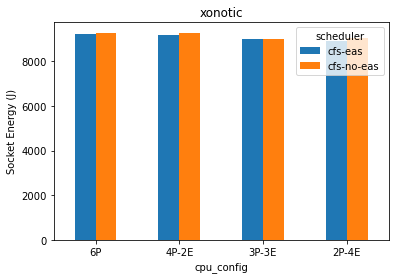

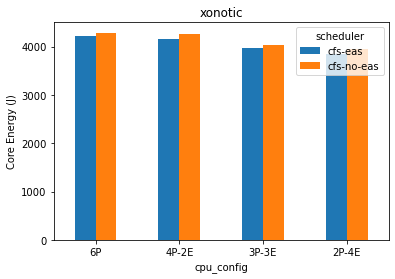

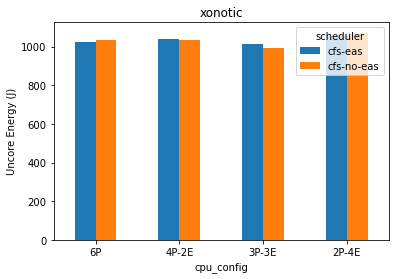

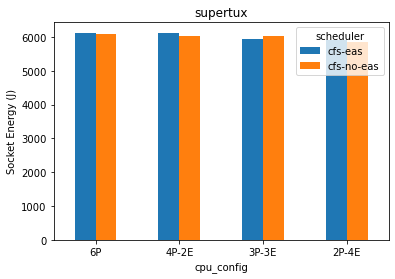

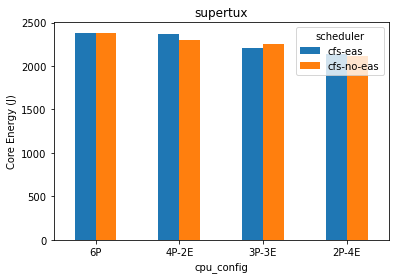

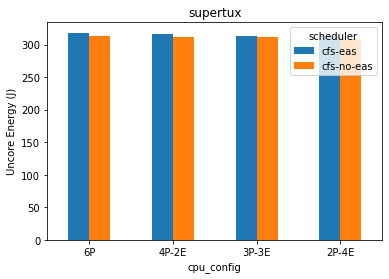

In [30]:
socket_game = to_game(socket)

for game in games:
    df = socket_game[game].groupby(cols_idx).sum(numeric_only=True).reset_index()
    t = pd.pivot_table(df, index=['cpu_config'], columns=['scheduler'], values=['socket', 'core', 'uncore']).iloc[::-1]
    
    t.plot.bar(y='socket', ylabel='Socket Energy (J)', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t.plot.bar(y='core', ylabel='Core Energy (J)', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t.plot.bar(y='uncore', ylabel='Uncore Energy (J)', title=game)
    plt.xticks(rotation=0)
    plt.show()

In [12]:
# sea = sns.FacetGrid(df, col='game', row='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'socket',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'core',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'uncore',
#        order = configs)
# sea.add_legend()
# plt.show()

In [13]:
list(game_perf_df.columns)

['fps',
 'frametime',
 'cpu_load',
 'gpu_load',
 'cpu_temp',
 'gpu_temp',
 'gpu_core_clock',
 'gpu_mem_clock',
 'gpu_vram_used',
 'gpu_power',
 'ram_used',
 'swap_used',
 'process_rss',
 'elapsed',
 'cpu_config',
 'scheduler',
 'game',
 'timedelta']

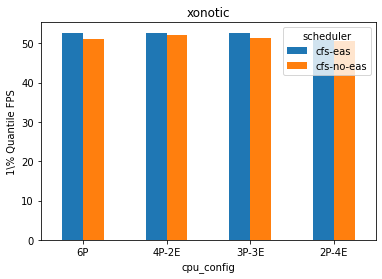

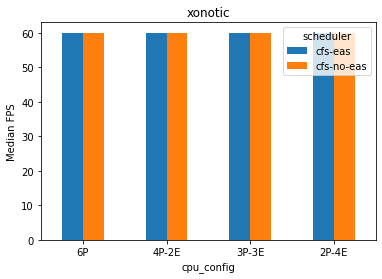

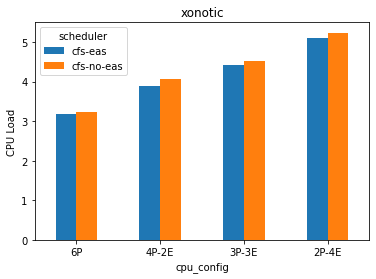

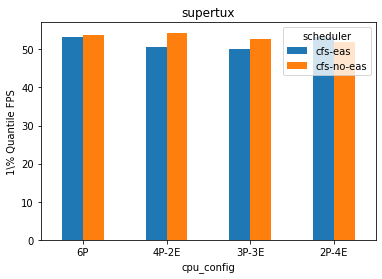

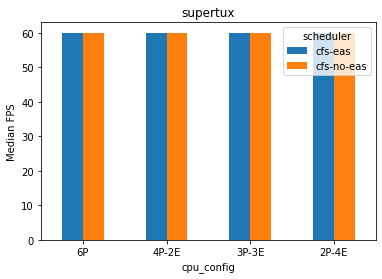

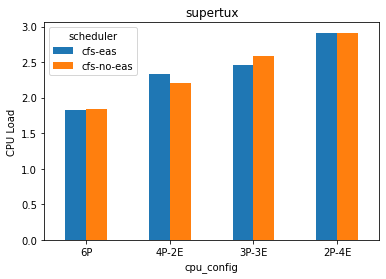

In [107]:
game_perf_game = to_game(game_perf_df)
cols_val = ['fps', 'cpu_load']

speedup_quant = {'config': {}, 'sched': {}}
speedup_median = {'config': {}, 'sched': {}}
speedup_mean = {'config': {}, 'sched': {}}

def normalize_by_config(df):
    for config in configs:
        df[config] /= df['6P']
    return df.T

def normalize_by_scheduler(df):
    for sched in scheds:
        df[sched] /= df['cfs-no-eas']
    return df.T

for game in games:
    df_quant_01 = game_perf_game[game].groupby(cols_idx).quantile(.01, numeric_only=True).reset_index()
    df_median = game_perf_game[game].groupby(cols_idx).median(numeric_only=True).reset_index()
    df_mean = game_perf_game[game].groupby(cols_idx).mean(numeric_only=True).reset_index()
    
    
    t_quant_01 = pd.pivot_table(df_quant_01, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    t_median = pd.pivot_table(df_median, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    t_mean = pd.pivot_table(df_mean, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    
    speedup_quant['config'][game] = pd.pivot_table(df_quant_01, columns=['cpu_config', 'scheduler'], values=cols_val).iloc[::-1]
    speedup_median['config'][game] = pd.pivot_table(df_mean, columns=['cpu_config', 'scheduler'], values=cols_val).iloc[::-1]
    speedup_mean['config'][game] = pd.pivot_table(df_mean, columns=['cpu_config', 'scheduler'], values=cols_val).iloc[::-1]
    
    speedup_quant['sched'][game] = pd.pivot_table(df_quant_01, columns=['cpu_config', 'scheduler'][::-1], values=cols_val).iloc[::-1]
    speedup_median['sched'][game] = pd.pivot_table(df_mean, columns=['cpu_config', 'scheduler'][::-1], values=cols_val).iloc[::-1]
    speedup_mean['sched'][game] = pd.pivot_table(df_mean, columns=['cpu_config', 'scheduler'][::-1], values=cols_val).iloc[::-1]
    
    speedup_quant['config'][game] = normalize_by_config(speedup_quant['config'][game])
    speedup_median['config'][game] = normalize_by_config(speedup_median['config'][game])
    speedup_mean['config'][game] = normalize_by_config(speedup_mean['config'][game])
    
    speedup_quant['sched'][game] = normalize_by_scheduler(speedup_quant['sched'][game])
    speedup_median['sched'][game] = normalize_by_scheduler(speedup_median['sched'][game])
    speedup_mean['sched'][game] = normalize_by_scheduler(speedup_mean['sched'][game])
    
    t_quant_01.plot.bar(y='fps', ylabel='1\% Quantile FPS', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_median.plot.bar(y='fps', ylabel='Median FPS', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_median.plot.bar(y='cpu_load', ylabel='CPU Load', title=game)
    plt.xticks(rotation=0)
    plt.show()


In [108]:
speedup_median['config']['xonotic'].reset_index()[['cpu_config', 'scheduler', 'cpu_load']]

,cpu_config,scheduler,cpu_load
0,2P-4E,cfs-eas,1.591239
1,2P-4E,cfs-no-eas,1.586089
2,3P-3E,cfs-eas,1.372381
3,3P-3E,cfs-no-eas,1.373420
4,4P-2E,cfs-eas,1.231022
5,4P-2E,cfs-no-eas,1.238081
6,6P,cfs-eas,1.000000
7,6P,cfs-no-eas,1.000000


In [111]:
1 / speedup_median['sched']['xonotic']['cpu_load']

scheduler   cpu_config
cfs-eas     2P-4E         1.018860
            3P-3E         1.022942
            4P-2E         1.028030
            6P            1.022168
cfs-no-eas  2P-4E         1.000000
            3P-3E         1.000000
            4P-2E         1.000000
            6P            1.000000
Name: cpu_load, dtype: float64

In [15]:
# df_quant_01 = game_perf_df.groupby(cols_idx).quantile(.01, numeric_only=True).reset_index()
# df_median = game_perf_df.groupby(cols_idx).median(numeric_only=True).reset_index()
# df_mean = game_perf_df.groupby(cols_idx).mean(numeric_only=True).reset_index()

In [16]:
# sea = sns.FacetGrid(df_quant_01, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'fps',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_median, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'cpu_load',
#        order = configs)
# sea.add_legend()
# plt.show()

# # sea = sns.FacetGrid(df_median, row='game', col='scheduler', margin_titles=True)
# # sea.map(sns.barplot, 'cpu_config', 'cpu_temp',
# #        order = configs)
# # sea.add_legend()
# # plt.show()

In [17]:
df_mean = pcm_df.groupby(cols_idx).mean(numeric_only=True).reset_index()
df_sum = pcm_df.groupby(cols_idx).sum(numeric_only=True).reset_index()

In [18]:
list(pcm_df.columns)

['Date',
 'Time',
 'EXEC',
 'IPC',
 'FREQ',
 'AFREQ',
 'CFREQ',
 'L3MISS',
 'L2MISS',
 'L3HIT',
 'L2HIT',
 'L3MPI',
 'L2MPI',
 'READ',
 'WRITE',
 'INST',
 'ACYC',
 'TIME(ticks)',
 'PhysIPC',
 'PhysIPC%',
 'INSTnom',
 'INSTnom%',
 'C0res%',
 'C1res%',
 'C3res%',
 'C6res%',
 'C7res%',
 'C0res%.1',
 'C2res%',
 'C4res%',
 'C6res%.1',
 'Proc Energy (Joules)',
 'Power Plane 0 Energy (Joules)',
 'Power Plane 1 Energy (Joules)',
 'EXEC.1',
 'IPC.1',
 'FREQ.1',
 'AFREQ.1',
 'CFREQ.1',
 'L3MISS.1',
 'L2MISS.1',
 'L3HIT.1',
 'L2HIT.1',
 'L3MPI.1',
 'L2MPI.1',
 'READ.1',
 'WRITE.1',
 'TEMP',
 'INST.1',
 'ACYC.1',
 'TIME(ticks).1',
 'PhysIPC.1',
 'PhysIPC%.1',
 'INSTnom.1',
 'INSTnom%.1',
 'C0res%.2',
 'C1res%.1',
 'C3res%.1',
 'C6res%.2',
 'C7res%.1',
 'C0res%.3',
 'C2res%.1',
 'C4res%.1',
 'C6res%.3',
 'SKT0',
 'SKT0.1',
 'SKT0.2',
 'EXEC.2',
 'IPC.2',
 'FREQ.2',
 'AFREQ.2',
 'CFREQ.2',
 'L3MISS.2',
 'L2MISS.2',
 'L3HIT.2',
 'L2HIT.2',
 'L3MPI.2',
 'L2MPI.2',
 'C0res%.4',
 'C1res%.2',
 'C3res%.2'

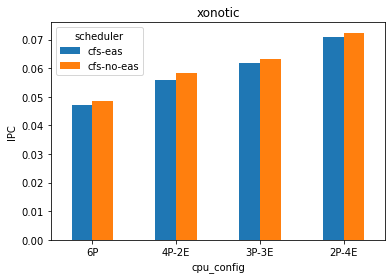

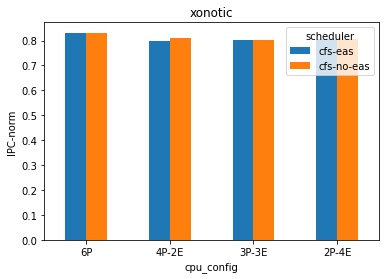

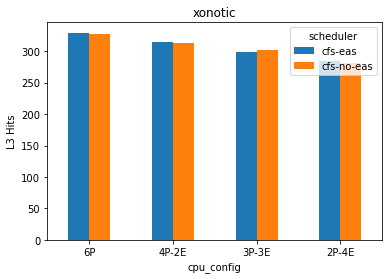

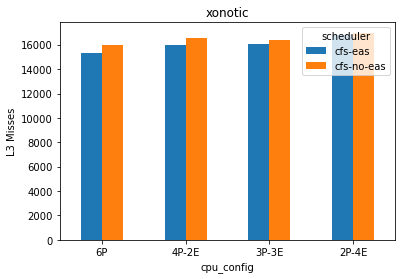

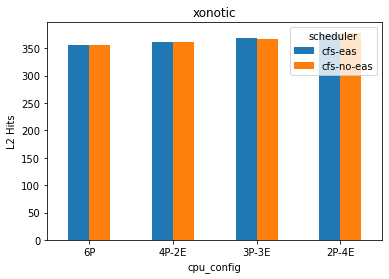

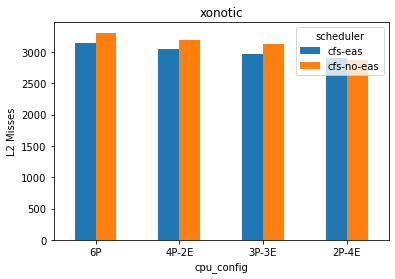

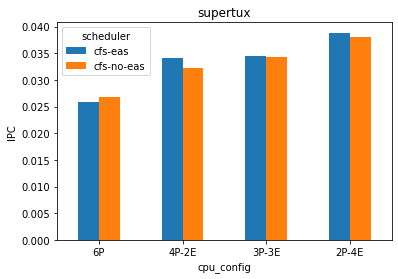

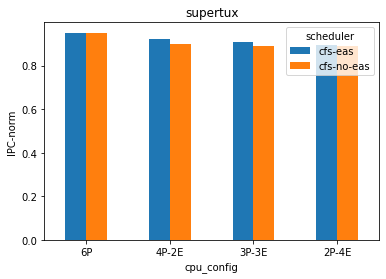

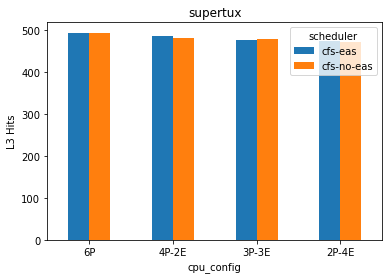

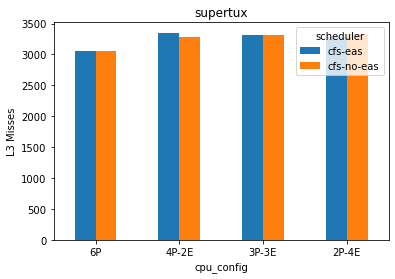

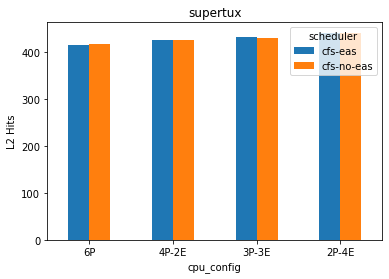

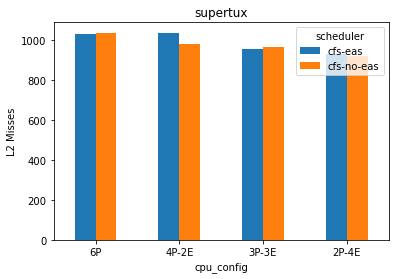

In [35]:
pcm_game = to_game(pcm_df)
cols_val = ['EXEC', 'IPC', 'FREQ', 'AFREQ', 'L3MISS', 'L3HIT', 'L3MPI', 'L2MISS', 'L2HIT', 'L2MPI', 'CFREQ',
           'PhysIPC', 'Proc Energy (Joules)', 'Power Plane 0 Energy (Joules)', 'Power Plane 1 Energy (Joules)',
           ]

for game in games:
    df_sum = pcm_game[game].groupby(cols_idx).sum(numeric_only=True).reset_index()
    df_median = pcm_game[game].groupby(cols_idx).median(numeric_only=True).reset_index()
    df_mean = pcm_game[game].groupby(cols_idx).mean(numeric_only=True).reset_index()
    
    
    t_sum = pd.pivot_table(df_sum, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    t_median = pd.pivot_table(df_median, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    t_mean = pd.pivot_table(df_mean, index=['cpu_config'], columns=['scheduler'], values=cols_val).iloc[::-1]
    
    
    t_mean.plot.bar(y='EXEC', ylabel='IPC', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_mean.plot.bar(y='IPC', ylabel='IPC-norm', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_sum.plot.bar(y='L3HIT', ylabel='L3 Hits', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_sum.plot.bar(y='L3MISS', ylabel='L3 Misses', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_sum.plot.bar(y='L2HIT', ylabel='L2 Hits', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
    t_sum.plot.bar(y='L2MISS', ylabel='L2 Misses', title=game)
    plt.xticks(rotation=0)
    plt.show()
    
#     t_mean.plot.bar(y='FREQ', ylabel='FREQ', title=game)
#     plt.xticks(rotation=0)
#     plt.show()
    
#     t_mean.plot.bar(y='AFREQ', ylabel='AFREQ', title=game)
#     plt.xticks(rotation=0)
#     plt.show()
    
#     t_mean.plot.bar(y='CFREQ', ylabel='CFREQ', title=game)
#     plt.xticks(rotation=0)
#     plt.show()
    
#     t_sum.plot.bar(y='Proc Energy (Joules)', ylabel='Proc Energy (Joules)', title=game)
#     plt.xticks(rotation=0)
#     plt.show()


In [20]:
pcm_sched_config = to_sched_config(pcm_df)


In [21]:
game_perf_sched_config = to_sched_config(game_perf_df)

In [22]:
game_power_sched_config = to_sched_config(game_power_df)

In [23]:
pd.to_datetime(pcm_df['Date'])

0     2024-03-06
1     2024-03-06
2     2024-03-06
3     2024-03-06
4     2024-03-06
         ...    
594   2024-03-06
595   2024-03-06
596   2024-03-06
597   2024-03-06
598   2024-03-06
Name: Date, Length: 9575, dtype: datetime64[ns]

In [24]:
pd.to_datetime?

In [25]:
# list(pcm_df.columns)

In [26]:
df.head()

,cpu_config,scheduler,game,timestamp,socket,core,uncore
0,2P-4E,cfs-eas,supertux,166642.323121,5899.164023,2138.189744,313.066678
1,2P-4E,cfs-no-eas,supertux,166985.144508,5853.667315,2117.640781,308.463650
2,3P-3E,cfs-eas,supertux,166258.175336,5933.972592,2211.696022,312.780441
3,3P-3E,cfs-no-eas,supertux,167959.351617,6026.262648,2249.325973,312.167463
4,4P-2E,cfs-eas,supertux,167308.785852,6121.521422,2373.302109,316.753518


In [27]:
# sea = sns.FacetGrid(df_mean, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'IPC',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_mean, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'EXEC',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_mean, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'FREQ',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_mean, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'AFREQ',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_mean, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'CFREQ',
#        order = configs)
# sea.add_legend()
# plt.show()

In [28]:
# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L2MISS',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L3MISS',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L2HIT',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L3HIT',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L2MPI',
#        order = configs)
# sea.add_legend()
# plt.show()

# sea = sns.FacetGrid(df_sum, row='game', col='scheduler', margin_titles=True)
# sea.map(sns.barplot, 'cpu_config', 'L3MPI',
#        order = configs)
# sea.add_legend()
# plt.show()

In [29]:
# config = configs[3]
# game = games[1]
# sched = scheds[1]

# path_prefix = f"results/results-{sched}/{game}/{config}"
# outputs = os.listdir(path_prefix)


# scaphandres = list(filter(lambda file: file.startswith('scaph'), outputs))
# scaphandres = list(filter(lambda file: file.endswith('parsed'), scaphandres))
# mangologs = list(filter(lambda file: file.startswith(game), outputs))
# pcms = list(filter(lambda file: file.startswith('pcm'), outputs))

# def suffix(x):
#     return x.split('/')[-1]


# host = []
# socket = []
# processes = []

# idx = 0

# scaph_2 = f"{path_prefix}/{scaphandres[idx]}"
# mango_2 = f"{path_prefix}/{mangologs[idx]}"
# pcm = f"{path_prefix}/{pcms[idx]}"

# with open(scaph_2) as file:
#     content = file.readlines()
#     for index, line in enumerate(content[:-1]):
#         if line.strip() != '':
#             line_ = json.loads(line)
#             host.append([line_['host']['timestamp'],line_['host']['consumption']])
#             socket.append([line_['sockets'][0]['domains'][0]['timestamp'],
#              line_['sockets'][0]['consumption'], 
#              line_['sockets'][0]['domains'][1]['consumption'], 
#              line_['sockets'][0]['domains'][0]['consumption']])
            
#             processes += list(map(
#                 lambda x: [x['timestamp'],suffix(x['exe']),x['pid'],x['consumption']], 
#                 line_['consumers']))

# host = pd.DataFrame(host, columns=['timestamp', 'energy'])
# socket = pd.DataFrame(socket, columns=['timestamp', 'socket', 'core', 'uncore'])
# processes = pd.DataFrame(processes, columns=['timestamp', 'process', 'pid', 'energy'])

# host['timestamp'] -= host.iloc[0].timestamp
# socket['timestamp'] -= socket.iloc[0].timestamp
# processes['timestamp'] -= processes.iloc[0].timestamp

# host['energy'] *= 1e-6
# socket['core'] *= 1e-6
# socket['uncore'] *= 1e-6
# socket['socket'] *= 1e-6
# processes['energy'] *= 1e-6

# duration = host.timestamp.iloc[-1] - host.timestamp.iloc[0]

# host['time_delta'] = host.timestamp.diff()
# host['edp'] = host.time_delta * host.energy

# processes['time_delta'] = processes.timestamp.diff()
# processes['edp'] = processes.time_delta * processes.energy

# mango_df = pd.read_csv(mango_2, skiprows=2)
# fps_1 = mango_df.fps.quantile(.01)
# fps_5 = mango_df.fps.quantile(.05)
# fps_mean = mango_df.fps.mean()
# fps_median = mango_df.fps.median()
# edp = host.edp.sum()
# energy = host.energy.sum()
# game_energy = processes.energy.sum()
# xonotic_consumption = processes[processes.process.str.startswith(game)]


# print(f"FPS 1% = {fps_1}")
# print(f"FPS 5% = {fps_5}")
# print(f"FPS 50% = {fps_median}")
# print(f"FPS mean = {fps_mean}")
# print(f"Duration = {duration}")
# print(f"EDP = {edp}")
# print(f"Energy = {energy}")
# print(f"Game Energy = {game_energy}")
# print(f"Power = {energy/duration}")


# host.plot(x='timestamp', y='energy', title='pcm-energy')
# plt.show()

# host.plot(x='timestamp', y='edp', title='pcm-edp')
# plt.show()

# mango_df.fps.hist(bins=100)
# plt.show()

# socket.plot(x='timestamp', y=['socket', 'core', 'uncore'], title='socket-energy')
# plt.show()

# xonotic_consumption.plot(x='timestamp', y='energy', title='App energy consumption')
# plt.show()

# processes.plot(x='timestamp', y='edp', title='app-edp')
# plt.show()


# # pcm_data = pd.read_csv(pcm, skiprows=1)

# # core = 3
# # metrics = [
# #     'EXEC',
# #     'IPC',
# #     'FREQ',
# #     'L3MISS',
# #     'L3HIT',
# #     'L2MISS',
# #     'L2HIT'
# # ]

# # cols = [f'{metric}.{core}' for metric in metrics]

# # pcm_data.plot(y=cols[1])
# # plt.show()

